<a href="https://colab.research.google.com/github/sh20022002/small-Language-Model/blob/main/notebooks/slm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%pip install -q "git+https://github.com/sh20022002/small-Language-Model.git@main"           # uses setup.py / pyproject at repo ROOT


import os, pathlib

# 1) Pick the actual clone dir you used
REPO = "/content/slm"  # change to your real clone path

# 2) Confirm the file exists (and discover the exact name/path)
!find /content -maxdepth 4 -iname "tokenizer*.pkl.gz" -print

# 3) Set the path to what you actually have (example filename below)
tok_path = f"{REPO}/src/my_slm/data/tokenizer_state.pkl.gz"


  Preparing metadata (setup.py) ... done


In [18]:
from datasets import load_dataset

from functools import partial

from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence

from my_slm.hybrid_tokeniztion import HybridTokenizer
from my_slm.transformer import Transformer
from my_slm.train import train_model
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


dataset = load_dataset("tatsu-lab/alpaca")


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
import os, my_slm


tok_path = os.path.join(os.path.dirname(my_slm.__file__),
                        "data", "tokenizer_state.pkl.gz")
print("Loading from:", tok_path)   # sanity
tok = HybridTokenizer.load(tok_path)


Loading from: /usr/local/lib/python3.12/dist-packages/my_slm/data/tokenizer_state.pkl.gz


In [21]:
dataset = dataset['train']

In [22]:
dataset[500]

{'instruction': 'Describe the character of Romeo from Romeo and Juliet.',
 'input': '',
 'output': 'Romeo is a tragic hero with a passionate heart. He is brave and impulsive, often making decisions without fully thinking them through. He is deeply romantic and has a heartbreaking loyalty to his family and his beloved, Juliet.',
 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe the character of Romeo from Romeo and Juliet.\n\n### Response:\nRomeo is a tragic hero with a passionate heart. He is brave and impulsive, often making decisions without fully thinking them through. He is deeply romantic and has a heartbreaking loyalty to his family and his beloved, Juliet.'}

In [23]:

class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Prepare raw text
        prompt = f"Q: {item['instruction']}\nA:"
        target = item['output']

        # Encode input and target using your tokenizer
        input_ids = self.tokenizer.encode(prompt, mode="flat")[:self.max_length]
        label_ids = self.tokenizer.encode(target, mode="flat")[:self.max_length]

        # Convert to tensors
        input_tensor = torch.tensor(input_ids, dtype=torch.long)
        label_tensor = torch.tensor(label_ids, dtype=torch.long)

        return {
            "input_ids": input_tensor,
            "labels": label_tensor
        }



def collate_fn(batch, pad_id=0, ignore_index=-100):
    # 1) pad to [B, T]
    ids = [b["input_ids"] for b in batch]                                  # each [T]
    ids = pad_sequence(ids, batch_first=True, padding_value=pad_id)        # [B, T]

    # 2) build attention mask from padded ids
    attn = (ids != pad_id).long()                                          # [B, T]

    # 3) labels align 1:1 with ids; ignore pads for loss
    labels = ids.clone()
    labels[ids == pad_id] = ignore_index                                   # [B, T]

    return {"input_ids": ids, "attention_mask": attn, "labels": labels}




In [24]:
# Split the dataset using the datasets library's built-in method
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)

# Access the splits
train_data_list = split_dataset['train']
val_data_list = split_dataset['test'] # The split method names the validation split 'test' by default

# Create QADataset instances from the split data
train_dataset = QADataset(train_data_list, tok)
val_dataset = QADataset(val_data_list, tok)



In [25]:


model = Transformer(
    vocab_size=len(tok.token2id),
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=2048,
    window=256
)


In [26]:

pad_id = tok.token2id["<PAD>"]      # numeric id (likely 0

# after you finish adding data to tokenizer and freeze it:
vocab = tok.vocab_size

BATCH = 8


In [27]:


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH,
    shuffle=True,
    collate_fn=partial(collate_fn, pad_id=pad_id, ignore_index=pad_id),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH,
    shuffle=False,
    collate_fn=partial(collate_fn, pad_id=pad_id, ignore_index=pad_id),
)

model.resize_token_embeddings(tok.vocab_size)

assert model.token_emb.num_embeddings == vocab
assert model.to_logits.out_features   == vocab

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


started Training...
Epoch 1/5 - Train Loss: 8.0560, Val Loss: 7.4371, Acc: 99.13%
Epoch 2/5 - Train Loss: 6.8637, Val Loss: 6.2980, Acc: 99.69%
Epoch 3/5 - Train Loss: 5.7382, Val Loss: 5.1904, Acc: 99.87%
Epoch 4/5 - Train Loss: 4.6560, Val Loss: 4.1431, Acc: 99.94%
Epoch 5/5 - Train Loss: 3.6638, Val Loss: 3.2174, Acc: 99.96%


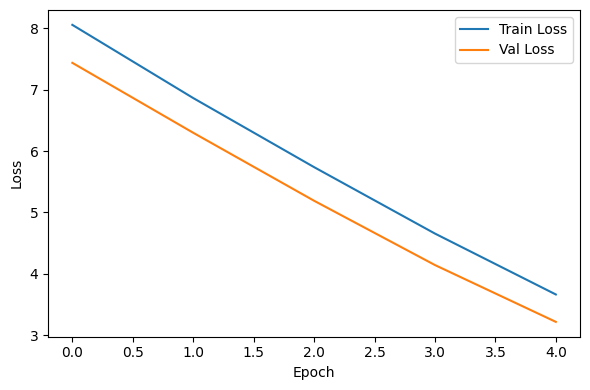

In [28]:

# IMPORTANT: pass the SAME ignore_index to the trainer
model = train_model(model, train_loader, val_loader, optimizer, device, epochs=5, ignore_index=pad_id)


In [29]:
q = "capital of france"
e_q = tok.encode(q, mode="flat")
i_tensor = torch.tensor(e_q, dtype=torch.long)
eos_id = tok.token2id.get("<EOS>")

out = model.generate(i_tensor.unsqueeze(0).to(device), max_new_tokens=50, eos_token_id=eos_id)
print(tok.decode(out[0].tolist()))

capital of franceWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW


The `TypeError` in the `train_test_split` function arises because `sklearn`'s `train_test_split` is not designed to directly handle custom PyTorch `Dataset` objects. To resolve this, we will first split the underlying data (the list of dictionaries) into training and validation sets using `train_test_split`, and then create `QADataset` instances for each split.